In [1]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import stim
import scienceplots
plt.style.use('science')
plt.rcParams['figure.dpi'] = 300
import matplotlib.colors as colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[colors.hex2color("#66c2a5"), colors.hex2color("#fc8d62"), colors.hex2color("#8da0cb"), colors.hex2color("#e78ac3"), colors.hex2color( "#a6d854")])
import pymatching
import networkx as nx
import itertools

from src.rotated_surface_code import RotatedCode
from src.graph_representation import get_syndrome_graph, get_node_feature_matrix, get_edges
from src.mwpm_prediction import compute_mwpm_reward
from src.gnn_model import EdgeWeightGNN, sample_weights_get_log_probs

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data
from qecsim.graphtools import mwpm

We check for Z_L, so we count the parity of Z on the western edge, (second entry in logical class [X_L, Z_L]), remove all nodes that are not X ([1, 0], orange plaquette) stabilizers and count the parity of edges along the western edge of the matching of the X ([1, 0]) stabizers. 

In [2]:
p = 0.1
d = 5
code = RotatedCode(d)

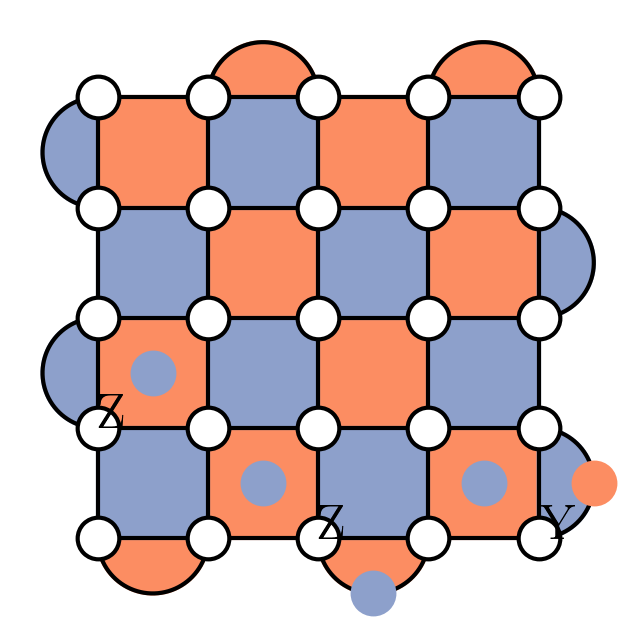

In [3]:
error = code.generate_error_chain(p)
eq_class = code.get_eq_class(error)
syndrome = code.get_syndrome(error)
fig, ax = plt.subplots()
code.plot_syndrome(syndrome=syndrome, error=error, ax=ax)

In [24]:
def get_syndrome_graph(code, p):
    error = code.generate_error_chain(p)
    eq_class = code.get_eq_class(error)
    y = torch.tensor(0, dtype=torch.float32) # the parity of Z errors on the western edge
    syndrome = code.get_syndrome(error)
    syndrome = np.array([[0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 1, 0, 0],
                         [0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0]])
    # check number of X stabilizers:
    if np.sum(syndrome == 1) == 0:
        return None
    else:
        node_features = get_node_feature_matrix(syndrome)
        edge_index, edge_attr = get_edges(node_features)
        graph = Data(x = node_features, edge_index = edge_index, edge_attr = edge_attr, y = y)
    
        return graph, syndrome, error

In [25]:
num_samples = 1
num_draws_per_sample = 100
graph_list = []
syndrome_list = []
error_list = []
stddev = torch.tensor(0.1, dtype=torch.float32)
while len(graph_list) < num_samples:
    out = get_syndrome_graph(code, p)
    if not out == None:
        graph, syndrome, error = out
        error_list.append(error)
        syndrome_list.append(syndrome)
        graph_list.append(graph)
        print(graph)


Data(x=[1, 4], edge_index=[2, 0], edge_attr=[0, 1], y=0.0)


In [26]:
model = EdgeWeightGNN()
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10000
loss_history, mean_history = [], []
for epoch in range(num_epochs):
    epoch_loss = []
    epoch_reward = []
    for i in range(num_samples):  # Draw multiple samples per epoch
        data = graph_list[i]
        all_log_probs = []
        all_rewards = []
        # Forward pass: Get sampled edge weights and their log-probabilities
        edge_index, edge_weights_mean, num_real_nodes, num_boundary_nodes = \
            model(data.x, data.edge_index, data.edge_attr)
        sampled_edge_weights, log_probs = sample_weights_get_log_probs(edge_weights_mean, num_draws_per_sample, stddev)
        sampled_edge_weights = torch.sigmoid(sampled_edge_weights)
        for j in range(num_draws_per_sample):
            edge_weights_j = sampled_edge_weights[j, :]
            reward, matching = compute_mwpm_reward(edge_index, edge_weights_j, num_real_nodes,num_boundary_nodes, data.y)
            # Store log-probabilities and rewards
            all_log_probs.append(log_probs[j, :])
            all_rewards.append(reward)
        # print(matching)
        # Stack log-probs and rewards for averaging
        all_log_probs = torch.stack(all_log_probs, dim=0)  # Shape: (num_draws_per_sample, num_edges)
        all_rewards = torch.tensor(all_rewards, dtype=torch.float32)            # Shape: (num_draws_per_sample,)
        # The loss per draw and per edge is the log-probability times the reward
        loss_per_draw = all_log_probs * all_rewards[:, None]  # Shape: (num_draws_per_sample, num_edges)

        # Compute the REINFORCE loss for each edge
        loss_per_sample = -torch.mean(loss_per_draw, dim=0)  # Shape: (num_edges,)
        mean_reward_per_sample = torch.mean(all_rewards)
        optimizer.zero_grad()
        loss_per_sample.backward(torch.ones_like(loss_per_sample))  # Provide gradient for each edge
        optimizer.step()

        # mean over all samples
        epoch_reward.append(mean_reward_per_sample.item())
        epoch_loss.append(loss_per_sample.mean().item())
    epoch_loss = torch.tensor(epoch_loss).mean()
    epoch_reward = torch.tensor(epoch_reward).mean()
    loss_history.append(epoch_loss)
    mean_history.append(edge_weights_mean.detach().numpy())
    # Print training progress
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.4f}, Mean Reward: {epoch_reward:.4f}')
loss_history = np.array(loss_history)
mean_history = np.array(mean_history)

Epoch [0/10000], Loss: -0.4469, Mean Reward: 0.3800


Epoch [100/10000], Loss: -0.8831, Mean Reward: 0.9800
Epoch [200/10000], Loss: -0.8987, Mean Reward: 0.9800
Epoch [300/10000], Loss: -0.8608, Mean Reward: 1.0000
Epoch [400/10000], Loss: -0.9127, Mean Reward: 1.0000
Epoch [500/10000], Loss: -0.9391, Mean Reward: 1.0000
Epoch [600/10000], Loss: -0.8099, Mean Reward: 1.0000
Epoch [700/10000], Loss: -1.0003, Mean Reward: 1.0000
Epoch [800/10000], Loss: -0.9022, Mean Reward: 1.0000
Epoch [900/10000], Loss: -0.8369, Mean Reward: 1.0000
Epoch [1000/10000], Loss: -0.8728, Mean Reward: 1.0000
Epoch [1100/10000], Loss: -0.8859, Mean Reward: 1.0000
Epoch [1200/10000], Loss: -0.8734, Mean Reward: 1.0000
Epoch [1300/10000], Loss: -0.9644, Mean Reward: 1.0000
Epoch [1400/10000], Loss: -0.8232, Mean Reward: 1.0000
Epoch [1500/10000], Loss: -0.8849, Mean Reward: 1.0000
Epoch [1600/10000], Loss: -1.0280, Mean Reward: 1.0000
Epoch [1700/10000], Loss: -0.8823, Mean Reward: 1.0000
Epoch [1800/10000], Loss: -0.9076, Mean Reward: 1.0000
Epoch [1900/10000],

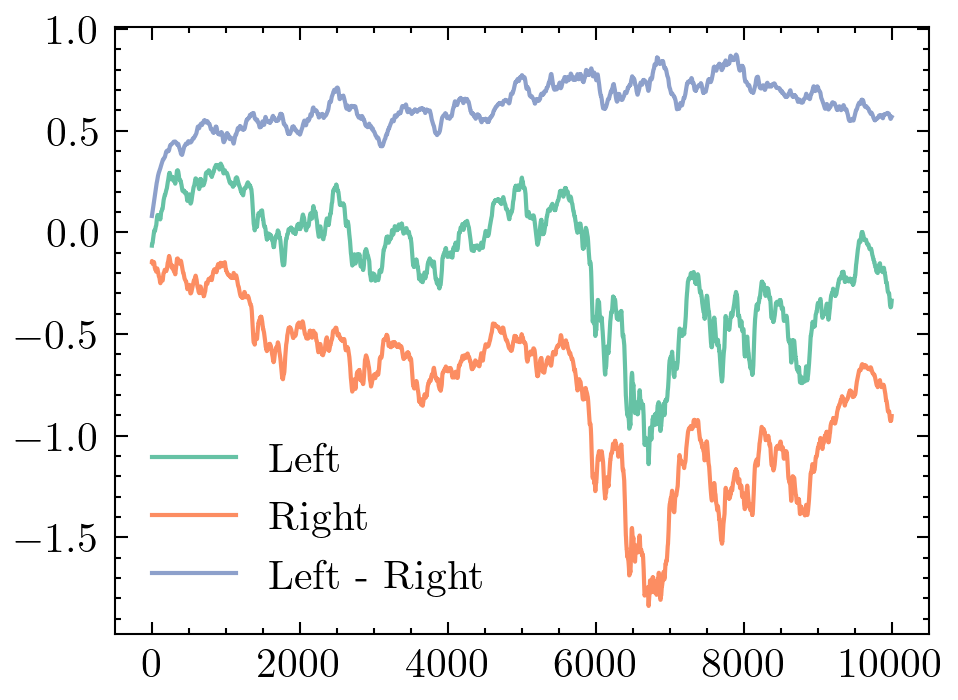

In [28]:
epoch = np.arange(num_epochs)
fig, ax = plt.subplots()
ax.plot(epoch, mean_history[:, 0], label = 'Left')
ax.plot(epoch, mean_history[:, 1], label = 'Right')
ax.plot(epoch, mean_history[:, 0] - mean_history[:, 1], label = 'Left - Right')
ax.legend(loc = 'lower left')

# events = [1800, 2900, 4400]
# for e in events:
#     ax.axvline(e, color = 'red', linestyle = '--')
